In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *

In [2]:
## Hyperparameters
dataset = 'horse2zebra'
load_size = 286
crop_size = 256
epoch = 5 # 200
batch_size = 1
learning_rate = 2e-4
channel = 3
cycle_loss_coef = 10
beta1 = .5

In [3]:
## Graph

# Placeholders
a_real_img_plhdr = tf.placeholder(tf.float32, (None, crop_size, crop_size, channel), name='a_real_images')
b_real_img_plhdr = tf.placeholder(tf.float32, (None, crop_size, crop_size, channel), name='b_real_images')
a_b_histry_plhdr = tf.placeholder(tf.float32, (None, crop_size, crop_size, channel), name='a_to_b_history_images')
b_a_histry_plhdr = tf.placeholder(tf.float32, (None, crop_size, crop_size, channel), name='b_to_a_history_images')

# CycleGAN Network

# Generators
gnrt_a_b     = generator(a_real_img_plhdr, scope='a_b')
gnrt_b_a     = generator(b_real_img_plhdr, scope='b_a')

gnrt_b_a_b   = generator(gnrt_b_a        , scope='a_b')
gnrt_a_b_a   = generator(gnrt_a_b        , scope='b_a')

# Discriminators
disc_a        = discriminator(a_real_img_plhdr, scope='a')
disc_b_a_real = discriminator(gnrt_b_a        , scope='a')
disc_b_a_hist = discriminator(b_a_histry_plhdr, scope='a')

disc_b        = discriminator(b_real_img_plhdr, scope='b')
disc_a_b_real = discriminator(gnrt_a_b        , scope='b')
disc_a_b_hist = discriminator(a_b_histry_plhdr, scope='b')

# Losses

g_loss_a_b    = tf.losses.mean_squared_error(labels=tf.ones_like(disc_a_b_real), predictions=disc_a_b_real)
g_loss_b_a    = tf.losses.mean_squared_error(labels=tf.ones_like(disc_b_a_real), predictions=disc_b_a_real)
cyc_loss_a    = tf.losses.absolute_difference(labels=a_real_img_plhdr          , predictions=gnrt_a_b_a)
cyc_loss_b    = tf.losses.absolute_difference(labels=b_real_img_plhdr          , predictions=gnrt_b_a_b)
sum_g_loss    = g_loss_a_b + g_loss_b_a + cycle_loss_coef * (cyc_loss_a + cyc_loss_b)

d_loss_a_real = tf.losses.mean_squared_error(labels=tf.ones_like(disc_a)        , predictions=disc_a)
d_loss_a_hist = tf.losses.mean_squared_error(labels=tf.zeros_like(disc_b_a_hist), predictions=disc_b_a_hist)
sum_d_loss_a  = d_loss_a_real + d_loss_a_hist

d_loss_b_real = tf.losses.mean_squared_error(labels=tf.ones_like(disc_b)        , predictions=disc_b)
d_loss_b_hist = tf.losses.mean_squared_error(labels=tf.zeros_like(disc_a_b_hist), predictions=disc_a_b_hist)
sum_d_loss_b  = d_loss_b_real + d_loss_b_hist

# Optimizers

all_vars = tf.trainable_variables()

disc_a_vars = [var for var in all_vars if 'a_discriminator' in var.name]
disc_b_vars = [var for var in all_vars if 'b_discriminator' in var.name]
gnrt_vars   = [var for var in all_vars if 'generator'       in var.name]

d_a_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(sum_d_loss_a, var_list=disc_a_vars)
d_b_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(sum_d_loss_b, var_list=disc_b_vars)
g_opt   = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(sum_g_loss  , var_list=gnrt_vars  )

In [4]:
## Images

sess = tf.Session()
# Train
trn_img_a_list  = glob.glob('../../data/' + dataset + '/trainA/*.jpg')
trn_img_b_list  = glob.glob('../../data/' + dataset + '/trainB/*.jpg')
trn_img_a_objt = ImageData(sess, trn_img_a_list,  batch_size=batch_size, load_size=load_size, crop_size=crop_size)
trn_img_b_objt = ImageData(sess, trn_img_b_list,  batch_size=batch_size, load_size=load_size, crop_size=crop_size)
# Test
tst_img_a_list  = glob.glob('../../data/' + dataset + '/trainA/*.jpg')
tst_img_b_list  = glob.glob('../../data/' + dataset + '/trainB/*.jpg')
tst_img_a_objt = ImageData(sess, tst_img_a_list,  batch_size=batch_size, load_size=load_size, crop_size=crop_size)
tst_img_b_objt = ImageData(sess, tst_img_b_list,  batch_size=batch_size, load_size=load_size, crop_size=crop_size)

a_b_hist_objt = ImageHistory()
b_a_hist_objt = ImageHistory()

In [5]:
# Train
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
loss_arr = []
for e in range(epoch):
    iter_num = min(len(trn_img_a_objt), len(trn_img_b_objt))// batch_size
    for itr in range(iter_num):
        # Get batch
        batch_a = trn_img_a_objt.batch()
        batch_b = trn_img_b_objt.batch()
        batch_a_b, batch_b_a = sess.run([gnrt_a_b, gnrt_b_a], feed_dict={a_real_img_plhdr:batch_a, b_real_img_plhdr:batch_b})
        batch_a_b_hist = np.array(a_b_hist_objt(list(batch_a_b)))
        batch_b_a_hist = np.array(b_a_hist_objt(list(batch_b_a)))
        # Optimize
        _, batch_g_loss   = sess.run([g_opt, sum_g_loss], feed_dict={a_real_img_plhdr:batch_a, b_real_img_plhdr:batch_b})
        _, batch_d_loss_b = sess.run([d_b_opt, sum_d_loss_b], feed_dict={b_real_img_plhdr:batch_b, a_b_histry_plhdr:batch_a_b_hist})
        _, batch_d_loss_a = sess.run([d_a_opt, sum_d_loss_a], feed_dict={a_real_img_plhdr:batch_a, b_a_histry_plhdr:batch_b_a_hist})

        loss_arr.append([batch_g_loss, batch_d_loss_b, batch_d_loss_a])
        if (itr+1) % 10 == 0:
            print("Epoch: %3d/%3d, Iteration: %5d/%5d, Disc a loss: %.4f, Disc b loss: %.4f, Gen loss: %.4f" %(e+1, epoch, itr+1, iter_num, batch_d_loss_a, batch_d_loss_b, batch_g_loss))

        # Save images during training
        if (itr+1) % 100 == 0:
            batch_a = tst_img_a_objt.batch()
            batch_b = tst_img_b_objt.batch()
            batch_a_b, batch_b_a, batch_b_a_b, batch_a_b_a = sess.run([gnrt_a_b, gnrt_b_a, gnrt_b_a_b, gnrt_a_b_a], feed_dict={a_real_img_plhdr:batch_a, b_real_img_plhdr:batch_b})
            image_concat = np.concatenate((batch_a, batch_a_b, batch_a_b_a, batch_b, batch_b_a, batch_b_a_b), axis=0)
            img_write(img_merge(image_concat,row=2,col=3), './Pictures/Training/%s/Epoch_%d_%d_Iteration_%d_%d.jpg' %(dataset,e+1, epoch, itr+1, iter_num))
saver.save(sess, '../../models/v4_CycleGAN/gen.ckpt')
sess.close()

Epoch:   1/  5, Iteration:    10/ 1067, Disc a loss: 1.5709, Disc b loss: 2.4571, Gen loss: 11.6625
Epoch:   1/  5, Iteration:    20/ 1067, Disc a loss: 0.9387, Disc b loss: 0.9372, Gen loss: 8.8563
Epoch:   1/  5, Iteration:    30/ 1067, Disc a loss: 1.0601, Disc b loss: 0.8963, Gen loss: 8.9345
Epoch:   1/  5, Iteration:    40/ 1067, Disc a loss: 0.7713, Disc b loss: 0.7174, Gen loss: 7.2221
Epoch:   1/  5, Iteration:    50/ 1067, Disc a loss: 0.6022, Disc b loss: 0.6883, Gen loss: 8.3640
Epoch:   1/  5, Iteration:    60/ 1067, Disc a loss: 0.4624, Disc b loss: 1.1587, Gen loss: 7.8950
Epoch:   1/  5, Iteration:    70/ 1067, Disc a loss: 0.7726, Disc b loss: 0.6046, Gen loss: 7.4094
Epoch:   1/  5, Iteration:    80/ 1067, Disc a loss: 0.5759, Disc b loss: 0.6262, Gen loss: 5.6285
Epoch:   1/  5, Iteration:    90/ 1067, Disc a loss: 0.6179, Disc b loss: 0.6178, Gen loss: 6.7993
Epoch:   1/  5, Iteration:   100/ 1067, Disc a loss: 0.9697, Disc b loss: 0.6386, Gen loss: 5.5714
Epoch:   

Epoch:   1/  5, Iteration:   840/ 1067, Disc a loss: 0.7488, Disc b loss: 0.4540, Gen loss: 4.6383
Epoch:   1/  5, Iteration:   850/ 1067, Disc a loss: 0.6086, Disc b loss: 0.3428, Gen loss: 6.6390
Epoch:   1/  5, Iteration:   860/ 1067, Disc a loss: 0.3420, Disc b loss: 0.3349, Gen loss: 4.4262
Epoch:   1/  5, Iteration:   870/ 1067, Disc a loss: 0.5271, Disc b loss: 0.4328, Gen loss: 5.6997
Epoch:   1/  5, Iteration:   880/ 1067, Disc a loss: 0.1527, Disc b loss: 0.3041, Gen loss: 9.8279
Epoch:   1/  5, Iteration:   890/ 1067, Disc a loss: 0.3511, Disc b loss: 0.6010, Gen loss: 5.3452
Epoch:   1/  5, Iteration:   900/ 1067, Disc a loss: 0.4630, Disc b loss: 0.2801, Gen loss: 5.3547
Epoch:   1/  5, Iteration:   910/ 1067, Disc a loss: 0.2123, Disc b loss: 0.4232, Gen loss: 6.8393
Epoch:   1/  5, Iteration:   920/ 1067, Disc a loss: 0.4953, Disc b loss: 0.6243, Gen loss: 4.7809
Epoch:   1/  5, Iteration:   930/ 1067, Disc a loss: 0.3845, Disc b loss: 0.3899, Gen loss: 5.0045
Epoch:   1

Epoch:   2/  5, Iteration:   610/ 1067, Disc a loss: 0.2895, Disc b loss: 0.3509, Gen loss: 5.9551
Epoch:   2/  5, Iteration:   620/ 1067, Disc a loss: 0.2431, Disc b loss: 0.4180, Gen loss: 3.5833
Epoch:   2/  5, Iteration:   630/ 1067, Disc a loss: 0.2508, Disc b loss: 0.3368, Gen loss: 4.6280
Epoch:   2/  5, Iteration:   640/ 1067, Disc a loss: 0.5253, Disc b loss: 0.4367, Gen loss: 5.1797
Epoch:   2/  5, Iteration:   650/ 1067, Disc a loss: 0.1775, Disc b loss: 0.3438, Gen loss: 7.5984
Epoch:   2/  5, Iteration:   660/ 1067, Disc a loss: 0.4624, Disc b loss: 0.4231, Gen loss: 4.4924
Epoch:   2/  5, Iteration:   670/ 1067, Disc a loss: 1.0145, Disc b loss: 0.3371, Gen loss: 5.1064
Epoch:   2/  5, Iteration:   680/ 1067, Disc a loss: 0.5663, Disc b loss: 0.1902, Gen loss: 4.8856
Epoch:   2/  5, Iteration:   690/ 1067, Disc a loss: 0.2805, Disc b loss: 0.3287, Gen loss: 5.5182
Epoch:   2/  5, Iteration:   700/ 1067, Disc a loss: 0.4965, Disc b loss: 0.7712, Gen loss: 3.7865
Epoch:   2

Epoch:   3/  5, Iteration:   380/ 1067, Disc a loss: 0.2955, Disc b loss: 0.3528, Gen loss: 4.3299
Epoch:   3/  5, Iteration:   390/ 1067, Disc a loss: 0.3771, Disc b loss: 0.1713, Gen loss: 5.4044
Epoch:   3/  5, Iteration:   400/ 1067, Disc a loss: 0.1118, Disc b loss: 0.1529, Gen loss: 5.1649
Epoch:   3/  5, Iteration:   410/ 1067, Disc a loss: 0.1325, Disc b loss: 0.4902, Gen loss: 6.3027
Epoch:   3/  5, Iteration:   420/ 1067, Disc a loss: 0.2424, Disc b loss: 0.3943, Gen loss: 5.1928
Epoch:   3/  5, Iteration:   430/ 1067, Disc a loss: 0.1809, Disc b loss: 0.4599, Gen loss: 5.8816
Epoch:   3/  5, Iteration:   440/ 1067, Disc a loss: 0.3850, Disc b loss: 0.2693, Gen loss: 7.4756
Epoch:   3/  5, Iteration:   450/ 1067, Disc a loss: 0.3264, Disc b loss: 0.0801, Gen loss: 7.1915
Epoch:   3/  5, Iteration:   460/ 1067, Disc a loss: 0.4032, Disc b loss: 0.1350, Gen loss: 7.2416
Epoch:   3/  5, Iteration:   470/ 1067, Disc a loss: 0.0949, Disc b loss: 0.1219, Gen loss: 6.2886
Epoch:   3

Epoch:   4/  5, Iteration:   150/ 1067, Disc a loss: 0.4576, Disc b loss: 0.2973, Gen loss: 2.9677
Epoch:   4/  5, Iteration:   160/ 1067, Disc a loss: 0.3085, Disc b loss: 0.4400, Gen loss: 4.3961
Epoch:   4/  5, Iteration:   170/ 1067, Disc a loss: 0.6845, Disc b loss: 0.2759, Gen loss: 3.8702
Epoch:   4/  5, Iteration:   180/ 1067, Disc a loss: 0.4109, Disc b loss: 0.4321, Gen loss: 3.3264
Epoch:   4/  5, Iteration:   190/ 1067, Disc a loss: 0.3123, Disc b loss: 0.4425, Gen loss: 4.7771
Epoch:   4/  5, Iteration:   200/ 1067, Disc a loss: 0.1156, Disc b loss: 0.2636, Gen loss: 5.2550
Epoch:   4/  5, Iteration:   210/ 1067, Disc a loss: 0.4162, Disc b loss: 0.5327, Gen loss: 4.7072
Epoch:   4/  5, Iteration:   220/ 1067, Disc a loss: 0.2162, Disc b loss: 0.4380, Gen loss: 4.6646
Epoch:   4/  5, Iteration:   230/ 1067, Disc a loss: 0.7255, Disc b loss: 0.2011, Gen loss: 3.4856
Epoch:   4/  5, Iteration:   240/ 1067, Disc a loss: 0.0396, Disc b loss: 0.3929, Gen loss: 4.4085
Epoch:   4

Epoch:   4/  5, Iteration:   980/ 1067, Disc a loss: 0.0714, Disc b loss: 0.3682, Gen loss: 4.5432
Epoch:   4/  5, Iteration:   990/ 1067, Disc a loss: 0.5524, Disc b loss: 0.2618, Gen loss: 5.0349
Epoch:   4/  5, Iteration:  1000/ 1067, Disc a loss: 0.5782, Disc b loss: 0.6995, Gen loss: 5.4834
Epoch:   4/  5, Iteration:  1010/ 1067, Disc a loss: 0.4384, Disc b loss: 0.0816, Gen loss: 4.3232
Epoch:   4/  5, Iteration:  1020/ 1067, Disc a loss: 0.0822, Disc b loss: 0.2298, Gen loss: 3.6783
Epoch:   4/  5, Iteration:  1030/ 1067, Disc a loss: 0.2553, Disc b loss: 0.3819, Gen loss: 3.6222
Epoch:   4/  5, Iteration:  1040/ 1067, Disc a loss: 0.2560, Disc b loss: 0.8321, Gen loss: 4.3877
Epoch:   4/  5, Iteration:  1050/ 1067, Disc a loss: 0.5767, Disc b loss: 0.5287, Gen loss: 3.5109
Epoch:   4/  5, Iteration:  1060/ 1067, Disc a loss: 0.1471, Disc b loss: 0.1444, Gen loss: 4.6384
Epoch:   5/  5, Iteration:    10/ 1067, Disc a loss: 0.4512, Disc b loss: 0.3603, Gen loss: 4.1255
Epoch:   5

Epoch:   5/  5, Iteration:   750/ 1067, Disc a loss: 0.1311, Disc b loss: 0.2898, Gen loss: 4.3938
Epoch:   5/  5, Iteration:   760/ 1067, Disc a loss: 0.5867, Disc b loss: 0.1476, Gen loss: 4.9035
Epoch:   5/  5, Iteration:   770/ 1067, Disc a loss: 0.2627, Disc b loss: 0.8407, Gen loss: 5.4159
Epoch:   5/  5, Iteration:   780/ 1067, Disc a loss: 0.3180, Disc b loss: 0.2640, Gen loss: 2.9799
Epoch:   5/  5, Iteration:   790/ 1067, Disc a loss: 0.1603, Disc b loss: 0.1493, Gen loss: 4.3177
Epoch:   5/  5, Iteration:   800/ 1067, Disc a loss: 0.6339, Disc b loss: 0.4793, Gen loss: 3.2270
Epoch:   5/  5, Iteration:   810/ 1067, Disc a loss: 0.5419, Disc b loss: 0.4673, Gen loss: 4.4293
Epoch:   5/  5, Iteration:   820/ 1067, Disc a loss: 0.3799, Disc b loss: 0.3170, Gen loss: 3.5792
Epoch:   5/  5, Iteration:   830/ 1067, Disc a loss: 0.7722, Disc b loss: 0.1031, Gen loss: 3.3392
Epoch:   5/  5, Iteration:   840/ 1067, Disc a loss: 0.6178, Disc b loss: 0.6588, Gen loss: 3.6969
Epoch:   5

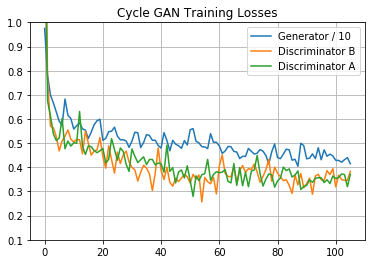

In [20]:
# Plot loss
# Let's average each 50 iteration to get a smoother graph
loss_np = np.asarray(loss_arr)
avg_np_g = loss_np.T[0,:1060*5]
avg_np_d_b = loss_np.T[1,:1060*5]
avg_np_d_a = loss_np.T[2,:1060*5]
avg_np_g = np.mean(avg_np_g.reshape(-1,50), axis=1)
avg_np_d_b = np.mean(avg_np_d_b.reshape(-1,50), axis=1)
avg_np_d_a = np.mean(avg_np_d_a.reshape(-1,50), axis=1)


plt.cla()
plt.plot(avg_np_g * 1. / 10, label='Generator / 10')
plt.plot(avg_np_d_b, label='Discriminator B')
plt.plot(avg_np_d_a, label='Discriminator A')
plt.grid()
plt.axis([-5, 110, .1, 1.0])
plt.title('Cycle GAN Training Losses')
plt.legend()
plt.show()

In [ ]:
# Restore Model

** Reference **

This [cycle GAN tutorial](https://github.com/LynnHo/CycleGAN-Tensorflow-PyTorch) coming from original paper website is used as a reference.